## Community Health Equity Lab: New York COVID19 Response Analysis

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from plotnine import *
#import bamboolib as bam

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit

pd.options.display.max_columns = 300
pd.set_option('display.max_rows', 500)
%matplotlib inline

In C:\Program Files\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Program Files\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Program Files\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## Data

In [2]:
ny = pd.read_csv('output/ny_final.csv')
ny.head()

,GEOID_ZIP,ALAND10,AWATER10,tot_pop,white,per_white,black,per_black,native,per_native,asian,per_asian,nativehawaiian,per_hawaiian,other,per_other,two_or_mor,per_two_or,male,female,under_5,per_under_5,5_to_9,per_5_to_9,10_to_14,per_10_to_14,15_to_19,per_15_to_19,20_to_24,per_20_to_24,25_to_29,per_25_to_29,30_to_34,per_30_to_34,35_to_39,per_35_to_39,40_to_44,per_40_to_44,45_to_49,per_45_to_49,50_to_54,per_50_to_54,55_to_59,per_55_to_59,60_to_64,per_60_to_64,65_to_69,per_65_to_69,70_to_74,per_70_to_74,75_to_79,per_75_to_79,80_to_84,per_80_to_89,80_and_over,per_80_and_over,disabled,per_disabled,unemployment_rate,tot_households_snap,households_snap,per_households_snap,tot_pop_mobility,same_house,moved_within_1yr,less_10k,10k_15k,15k_25k,25k_35k,35k_50k,50k_75k,75k_100k,100k_150k,150k_200k,more_200k,med_income,mean_incom,speaks_only_english,naturalized,non_citizen,pop_pov,pop_below_,pcnt_pov,families_on_suplimental_income,families_on_social_security,2_ppl_fam,3_to_4_ppl,5_to_6_ppl,GT_7_ppl_f,insured,per_insured,uninsured,per_uninsured,owner,rent,per_minority,minority-majority-50,minority-majority-60,minority-majority-70,4_16_2020_positive,4_16_2020_tests,4_16_2020_positive_rate,4_2_2020_positive,4_2_2020_tests,4_2_2020_positive_rate,4_3_2020_positive,4_3_2020_tests,4_3_2020_positive_rate,4_7_2020_positive,4_7_2020_tests,4_7_2020_positive_rate,4_8_2020_positive,4_8_2020_tests,4_8_2020_positive_rate,hospital_count,3_26_bb_beds,4_2_bb_beds,4_7_bb_beds,licensed_beds,staffed_beds,ICU_beds,adult_icu_beds,pediatrics_icu_beds,bed_utilization_rate,potential_increase_bed_capacity,avg_ventilator_use,GEOID10,borough,sub_region_2,retail_and_recreation_percent_change_from_baseline_sum,grocery_and_pharmacy_percent_change_from_baseline_sum,parks_percent_change_from_baseline_sum,transit_stations_percent_change_from_baseline_sum,workplaces_percent_change_from_baseline_sum,residential_percent_change_from_baseline_sum,pop_density,per_infected,change_in_bed
0,10065,984654,0,28109,24285,86.4,619,2.2,37,0.1,2666,9.5,0,0.0,154,0.5,348,1.2,12248,15861,1650,5.9,1000,3.6,916,3.3,356,1.3,1785,6.4,2671,9.5,3176,11.3,2558,9.1,1607,5.7,1570,5.6,1796,6.4,1460,5.2,1522,5.4,1388,4.9,1486,5.3,1159,4.1,954,3.4,1055,3.8,1894,6.8,70.2,14844,414,2.8,27635,22612,2247,5.0,2.7,4.0,2.7,6.2,10.6,8.8,14.4,9.8,35.8,127375,242978,19681,3045,3306,27963,1922,3.0,109,1683,3797,2267,275,13,27299,97.3,744,2.7,5365,9479,13.5,0,0,0,233,682,34.16,121,385,0.314286,121,385,0.314286,171,492,34.76,187,544,34.38,14,7625,7993,7993,6493,5519,745,745,402,6.647990,974,181,10065,Manhattan,Manhattan,-2296,-1006,-1544,-2199,-1926,777,0.028547,0.008289,368
1,10069,249050,0,5085,3155,62.0,148,2.9,0,0.0,1558,30.6,0,0.0,0,0.0,224,4.4,2354,2731,368,7.2,416,8.2,274,5.4,95,1.9,235,4.6,427,8.4,594,11.7,639,12.6,508,10.0,374,7.4,378,7.4,235,4.6,197,3.9,61,1.2,87,1.7,109,2.1,0,0.0,88,1.7,182,3.6,74.7,2552,73,2.9,5025,3790,859,8.7,3.2,0.0,9.8,5.7,4.2,14.7,11.4,11.6,30.9,110625,225183,2922,331,1207,5085,522,7.3,25,88,517,662,27,0,4992,98.2,93,1.8,675,1877,37.9,0,0,0,40,105,38.10,24,57,0.421053,24,57,0.421053,29,72,40.28,32,81,39.51,9,4922,4922,4922,4093,3765,410,410,273,4.741397,328,138,10069,Manhattan,Manhattan,-2296,-1006,-1544,-2199,-1926,777,0.020418,0.007866,0
2,10075,477137,0,21556,18396,85.3,677,3.1,225,1.0,1047,4.9,0,0.0,902,4.2,309,1.4,10096,11460,1041,4.8,1252,5.8,736,3.4,763,3.5,778,3.6,1400,6.5,2022,9.4,1643,7.6,1148,5.3,1453,6.7,1244,5.8,1118,5.2,1131,5.2,1561,7.2,1276,5.9,1169,5.4,570,2.6,1251,5.8,1689,8.0,68.1,11035,217,2.0,21381,18455,1508,1.9,0.8,4.8,6.4,5.0,12.8,10.6,17.9,9.6,30.3,137146,233358,13727,3315,2372,21155,1075,4.5,129,1401,3133,1765,236,0,20715,97.9,440,2.1,4933,6102,14.6,0,0,0,294,631,46.59,160,371,0.431267,160,371,0.431267,204,452,45.13,232,501,46.31,15,7573,7729,7729,6277,5678,788,788,412,7.253486,599,198,10075,Manhattan,Manhattan,-2296,-1006,-1544,-2199,-1926,777,0.045178,0.013639,156
3,10128,1206191,0,59256,47167,79.6,2182,3.7,0,0.0,5844,9.9,0,0.0,1666,2.8,2397,4.0,25338,33918

### Visualizations

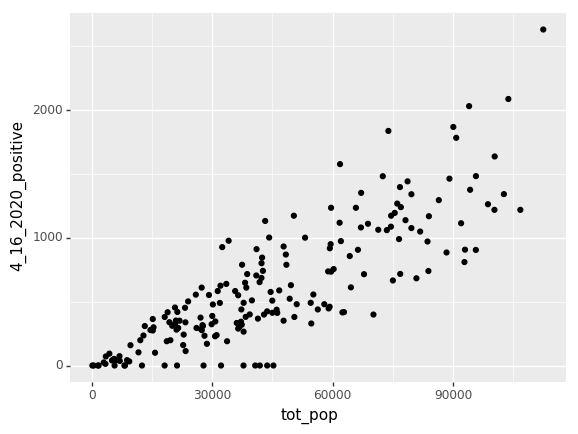

<ggplot: (-9223371874807145164)>

In [20]:
(ggplot(ny, aes(x='tot_pop', y='4_16_2020_positive'))+geom_point())

#### Function

In [21]:
def lebron(pop,c0,c1,c2,c3):
    return c0+c1*pop-c2*np.exp(-c3*pop)

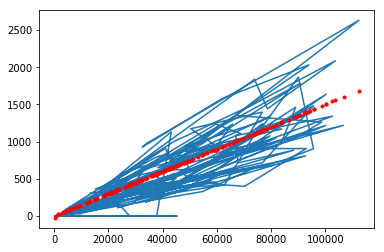

In [22]:
guess = [0,.015,200,.01]
n = len(ny['tot_pop'])
y = np.empty(n)

for i in range(n):
    y[i] = lebron(ny['tot_pop'][i],guess[0],guess[1],guess[2],guess[3])
    
plt.plot(ny['tot_pop'], ny['4_16_2020_positive'])
plt.plot(ny['tot_pop'], y, 'r.')

In [23]:
tp = ny['tot_pop'].values
pc = ny['4_16_2020_positive'].values

c,cov = curve_fit(lebron,tp,pc,guess)
print(c)

[-6.37787577e+01  1.50141071e-02  5.85137788e+03  1.69315501e-01]


C:\Program Files\Anaconda\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


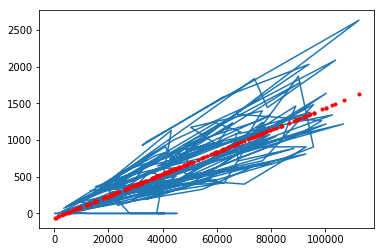

In [24]:
n = len(ny['tot_pop'])
y = np.empty(n)

for i in range(n):
    y[i] = lebron(ny['tot_pop'][i],c[0],c[1],c[2],c[3])
    
plt.plot(ny['tot_pop'], ny['4_16_2020_positive'])
plt.plot(ny['tot_pop'], y, 'r.')

In [41]:
ny_test = ny.rename(columns={"4_16_2020_positive": "positive"})

In [46]:
model = smf.ols(formula='positive~tot_pop + pcnt_pov', data=ny_test)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               positive   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     226.6
Date:                Fri, 15 May 2020   Prob (F-statistic):           3.81e-51
Time:                        13:33:23   Log-Likelihood:                -1357.6
No. Observations:                 194   AIC:                             2721.
Df Residuals:                     191   BIC:                             2731.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -93.1926     39.547     -2.356      0.0

In [45]:
model = smf.ols(formula='positive~ lebron(tot_pop,c[0],c[1],c[2],c[3]) + pcnt_pov', data=ny_test)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               positive   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     226.6
Date:                Fri, 15 May 2020   Prob (F-statistic):           3.81e-51
Time:                        13:32:43   Log-Likelihood:                -1357.6
No. Observations:                 194   AIC:                             2721.
Df Residuals:                     191   BIC:                             2731.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [49]:
ny.columns.values

array(['GEOID_ZIP', 'ALAND10', 'AWATER10', 'tot_pop', 'white',
       'per_white', 'black', 'per_black', 'native', 'per_native', 'asian',
       'per_asian', 'nativehawaiian ', 'per_hawaiian', 'other',
       'per_other', 'two_or_mor', 'per_two_or', 'male', 'female',
       'under_5', 'per_under_5', '5_to_9', 'per_5_to_9', '10_to_14',
       'per_10_to_14', '15_to_19', 'per_15_to_19', '20_to_24',
       'per_20_to_24', '25_to_29', 'per_25_to_29', '30_to_34',
       'per_30_to_34', '35_to_39', 'per_35_to_39', '40_to_44',
       'per_40_to_44', '45_to_49', 'per_45_to_49', '50_to_54',
       'per_50_to_54', '55_to_59', 'per_55_to_59', '60_to_64',
       'per_60_to_64', '65_to_69', 'per_65_to_69', '70_to_74',
       'per_70_to_74', '75_to_79', 'per_75_to_79', '80_to_84',
       'per_80_to_89', '80_and_over', 'per_80_and_over', 'disabled',
       'per_disabled', 'unemployment_rate', 'tot_households_snap',
       'households_snap', 'per_households_snap', 'tot_pop_mobility',
       'same_hous

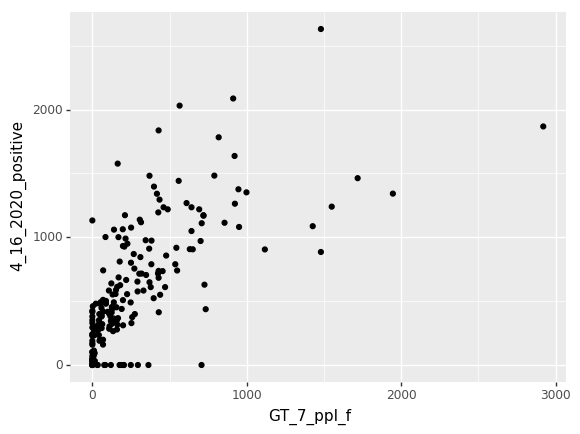

<ggplot: (-9223371874806921684)>

In [65]:
(ggplot(ny, aes(x='GT_7_ppl_f', y='4_16_2020_positive'))+geom_point())

In [55]:
def kobe(pop,c0,c1,c2,c3):
    return c0+c1*pop-c2*np.exp(-c3*pop)

In [66]:
tp = ny['GT_7_ppl_f'].values
pc = ny['4_16_2020_positive'].values

c,cov = curve_fit(kobe,tp,pc,guess)
print(c)

[1.21909129e+03 1.85433417e-01 1.03267111e+03 2.17136626e-03]


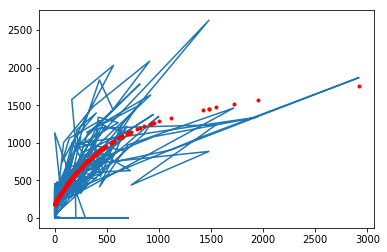

In [67]:
n = len(ny['GT_7_ppl_f'])
y = np.empty(n)

for i in range(n):
    y[i] = kobe(ny['GT_7_ppl_f'][i],c[0],c[1],c[2],c[3])
    
plt.plot(ny['GT_7_ppl_f'], ny['4_16_2020_positive'])
plt.plot(ny['GT_7_ppl_f'], y, 'r.')

In [68]:
model = smf.ols(formula='positive~GT_7_ppl_f + pcnt_pov', data=ny_test)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               positive   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     93.47
Date:                Fri, 15 May 2020   Prob (F-statistic):           4.95e-29
Time:                        14:43:21   Log-Likelihood:                -1409.3
No. Observations:                 194   AIC:                             2825.
Df Residuals:                     191   BIC:                             2834.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    255.9227     42.688      5.995      0.0

In [69]:
model = smf.ols(formula='positive~ kobe(GT_7_ppl_f,c[0],c[1],c[2],c[3]) + pcnt_pov', data=ny_test)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               positive   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     124.7
Date:                Fri, 15 May 2020   Prob (F-statistic):           2.29e-35
Time:                        14:43:26   Log-Likelihood:                -1394.5
No. Observations:                 194   AIC:                             2795.
Df Residuals:                     191   BIC:                             2805.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------